In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
agg_comments_df = pd.read_csv('../data/aggression_annotated_comments.tsv', sep='\t')
agg_comments_df.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,True,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,True,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train


In [3]:
agg_annot_df = pd.read_csv('../data/aggression_annotations.tsv', sep='\t')
agg_annot_df.head()

,rev_id,worker_id,aggression,aggression_score
0,37675,1362,1.0,-1.0
1,37675,2408,0.0,1.0
2,37675,1493,0.0,0.0
3,37675,1439,0.0,0.0
4,37675,170,0.0,0.0


In [4]:
# drop worker_id column
agg_annot_df.drop(columns='worker_id', inplace=True)

In [5]:
agg_annot_df.isnull().sum()

rev_id              0
aggression          0
aggression_score    0
dtype: int64

In [6]:
# create a new dataframe to calculate the mean of the 'aggression' for each comment
agg_1_df = agg_annot_df.groupby(['rev_id']).mean()
agg_1_df.head()

,aggression,aggression_score
rev_id,,
37675,0.100000,0.000000
44816,0.000000,0.111111
49851,0.000000,0.100000
89320,0.444444,-0.444444
93890,0.000000,0.333333


In [7]:
# identify as aggressive if at least five reviewers reported the comment to be aggressive
agg_1_df['label'] = agg_1_df['aggression'].map(lambda x: 1 if x>= 0.5 else 0)

In [8]:
agg_1_df['label'].value_counts(normalize=True)

0    0.853121
1    0.146879
Name: label, dtype: float64

This identified 14.7% of the comments to be aggressive and 85.3% to be non-aggressive.

In [9]:
# create a new dataframe to calculate the total score of the 'aggression score' for each comment
agg_2_df = agg_annot_df.groupby(['rev_id']).sum()
agg_2_df.head()

,aggression,aggression_score
rev_id,,
37675,1.0,0.0
44816,0.0,1.0
49851,0.0,1.0
89320,4.0,-4.0
93890,0.0,3.0


In [10]:
# identify as aggressive if the total score is -5 or less for 'aggressive score'
agg_2_df['label'] = agg_2_df['aggression_score'].map(lambda x: 1 if x<= -6 else 0)

In [11]:
agg_2_df['label'].value_counts(normalize=True)

0    0.816664
1    0.183336
Name: label, dtype: float64

This identified 18.3% of comments to be aggressive and 81.7% to be non-aggressive.

Setting the threshold of the score to -6 would label a comment to be aggressive if at least t six people determined the comment to be aggressive, three people determined the comment to be very aggressive, or a combination of scores that would lead to a total score of -6.

In [12]:
# check the number of rev_ids for each comment
agg_annot_df['rev_id'].value_counts().value_counts()

10    56207
9     29118
8      7404
19     6892
20     6181
18     3587
29     1375
28     1336
17     1205
27      771
30      713
26      364
16      326
25      133
15       90
24       39
14       34
23       24
22       13
12       12
13       11
11        7
31        4
36        4
39        4
37        3
21        2
34        1
35        1
38        1
45        1
46        1
Name: rev_id, dtype: int64

We will identify "aggression" if at least half of the reviewers reported the comment to be aggressive. This is based on the 'aggression' column with the value of 1 being aggression was detected by the reviewer and 0 if the comment was perceived as neutral or positive by the reviewer. The label column that was created based on the sum of the 'aggression score' will not be a good indicator since the number of reviewers can vastly differ for each comment and there is a risk of reviewers inflating the results.

In [13]:
aggression_df = agg_comments_df.merge(agg_1_df, how='left', on='rev_id')
aggression_df.head()

,rev_id,comment,year,logged_in,ns,sample,split,aggression,aggression_score,label
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train,0.100000,0.000000,0
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,True,article,random,train,0.000000,0.111111,0
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,True,article,random,train,0.000000,0.100000,0
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,0.444444,-0.444444,0
4,93890,This page will need disambiguation.,2002,True,article,random,train,0.000000,0.333333,0


In [14]:
# create a function to remove the 'NEWLINE_TOKEN' and non-alphanumeric text
def clean_alnum(text):
    if 'NEWLINE_TOKEN' in text:
        text = text.replace('NEWLINE_TOKEN','')
    for char in text:
        if char.isalnum() == False and char != ' ':
            text = text.replace(char,'')
    return text

In [15]:
aggression_df['comment'] = aggression_df['comment'].apply(clean_alnum)

In [16]:
aggression_df.head()

,rev_id,comment,year,logged_in,ns,sample,split,aggression,aggression_score,label
0,37675,This is not creative Those are the dictionary...,2002,True,article,random,train,0.100000,0.000000,0
1,44816,the term standard model is itself less NPOV t...,2002,True,article,random,train,0.000000,0.111111,0
2,49851,True or false the situation as of March 2002 w...,2002,True,article,random,train,0.000000,0.100000,0
3,89320,Next maybe you could work on being less conde...,2002,True,article,random,dev,0.444444,-0.444444,0
4,93890,This page will need disambiguation,2002,True,article,random,train,0.000000,0.333333,0


In [17]:
# review most common comments (occuring more than three times)
aggression_df['comment'].value_counts().sort_values(ascending=False)[:10]

Thank you for experimenting with  Wikipedia Your test worked and it has been reverted or removed Please use the sandbox for any other tests you may want to do Take a look at the welcome page to learn more about contributing to our encyclopedia        21
Please do not add nonsense to Wikipedia It is considered vandalism If you would like to experiment use the sandbox Thank you                                                                                                                               11
                                                                                                                                                                                                                                                           10
                                                                                                                                                                                                                                              

In [18]:
# review the number of different comments for each frequency of comments
aggression_df['comment'].value_counts().value_counts().sort_index(ascending=False)

21         1
11         1
10         4
9          1
8          2
7          4
6          1
5         10
4         22
3         34
2        267
1     114959
Name: comment, dtype: int64

It looks as though most of these comments are automated messages, and therefore should not be considered a valid observation in our dataset.

In [19]:
# create a list of the duplicate comments that are found more than two times
invalid_comment_list = aggression_df['comment'].value_counts().sort_values(ascending=False)[:80]

In [20]:
aggression_df.shape

(115864, 10)

In [21]:
# create a function that removes rows with the invalid comments above
drop_list=[]
def drop_invalid_rows(series):
    for i in range(len(series)):
        if series[i] in invalid_comment_list:
            drop_list.append(i)
    aggression_df.drop(drop_list, inplace=True)
    aggression_df.reset_index(drop=True, inplace=True)
    print(f'Dropped {len(drop_list)} rows.')
    print(f'There are {aggression_df.shape[0]} rows remaining.')
    return

In [22]:
# run the function on comments
drop_invalid_rows(aggression_df['comment'])

Dropped 371 rows.
There are 115493 rows remaining.


In [23]:
# save the cleaned dataset as CSV
aggression_df.to_csv('../data/aggression_clean_data.csv', index=False)

In [24]:
# create dataframes splitting the aggressive and non-aggressive comments
comments_aggressive = aggression_df[aggression_df['label']==1]['comment']
comments_nonaggressive = aggression_df[aggression_df['label']==0]['comment']

In [25]:
# Instantiate CountVectorizer with stopwords, token_patterns, and strip non-English texts
cvec = CountVectorizer(stop_words = 'english', token_pattern = r'\w+|[A-Z]\w+', strip_accents = 'ascii')

In [26]:
# Fit and transform the aggressive text
comments_aggressive = cvec.fit_transform(comments_aggressive)

In [27]:
# convert aggressive Count-Vectorized text to dataframe
comments_aggressive_df = pd.DataFrame(comments_aggressive.todense(),
                         columns=cvec.get_feature_names())

In [28]:
comments_aggressive_df.head()

,0,00,000,00000000,000000001,0003,001,0019,0025,0036,...,zut,zviadist,zwecke,zweifelsfall,zweifelsfalle,zwischen,zyklon,zyzzyxrd,zzuuzz,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
comments_aggressive_df.shape

(17000, 48175)

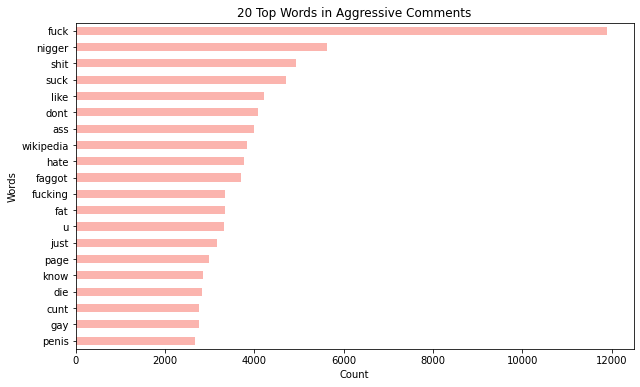

In [30]:
# Plot 20 top words in aggressive comments
plt.figure(figsize=(10,6))
comments_aggressive_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh', cmap='Pastel1')
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('20 Top Words in Aggressive Comments');

In [31]:
# review the most aggressive comments
aggression_df[aggression_df['aggression'] == 1]['comment'][:10]

207     fuck off you little asshole If you want to tal...
492      renault you sad little bpy for driving a rena...
696      GOD DAMN GOD DAMN it fuckers i am using the G...
769      WHY ARE YOU SUCH A GAY NIGGER GOD DAMNDD YOU ...
798      whoa you are a big fat idot stop spamming my ...
894     LOL charles you are a real fag arent you sidin...
895     WOW MIRV IS TEH protect THIS PAEGLOL CHARLESMI...
1003    Yeah what the fuck is this Get your lazy commi...
1004    FUCK YOU ALKIVA wikipedia is a democracy a wor...
1020               Can I EyeFUCK YOU YOU NEGRO SEE GROW  
Name: comment, dtype: object

In [32]:
# review the most neutral/positive comments
aggression_df[aggression_df['aggression'] == 0]['comment'][:10]

1      the term standard model is itself less NPOV t...
2     True or false the situation as of March 2002 w...
4                   This page will need disambiguation 
5     Important note for all sysops There is a bug i...
6     I removed the followingAll names of early Poli...
8     My apologies  Im English I watch cricket I kno...
10    Correct Full biographical details will put dow...
11    Care should be taken to distinguish when and i...
13    On my  you will find the apology that I owe yo...
14    I fail to see the distinction  Who better than...
Name: comment, dtype: object

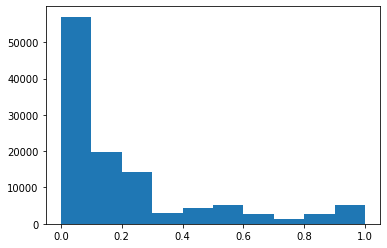

In [33]:
# view the distribution of average aggression labels on each comment
plt.hist(aggression_df['aggression']);

In [34]:
# Fit and transform the non-aggressive text
comments_nonaggressive = cvec.fit_transform(comments_nonaggressive)

In [35]:
# convert non-aggressive Count-Vectorized text to dataframe
comments_nonaggressive_df = pd.DataFrame(comments_nonaggressive.todense(),
                         columns=cvec.get_feature_names())

In [36]:
comments_nonaggressive_df.head()

,0,00,000,0000,000000,00000000027,00000035,000000rowspan2,000010,000012,...,zzyzwicz,zzz,zzzmidnights,zzzzall,zzzzz,zzzzzzus,zzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
comments_nonaggressive_df.shape

(98493, 215801)

In [39]:
# Instantiate CountVectorizer adding min_df
cvec_2 = CountVectorizer(stop_words = 'english', token_pattern = r'\w+|[A-Z]\w+', strip_accents = 'ascii', min_df=2)

In [41]:
# Fit and transform the aggressive text
comments_aggressive = aggression_df[aggression_df['label']==1]['comment']
comments_aggressive = cvec_2.fit_transform(comments_aggressive)

In [43]:
# convert aggressive Count-Vectorized text to dataframe
comments_aggressive_df = pd.DataFrame(comments_aggressive.todense(),
                         columns=cvec_2.get_feature_names())
comments_aggressive_df.head()

,0,000,0003,01,01082006,01em,021506,02152007,02172006,02222007,...,zomfg,zomg,zone,zoo,zoom,zorzi,zu,zuckerberg,zuma,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# Check number of columns
comments_aggressive_df.shape[1]

17923

In [48]:
# Instantiate CountVectorizer adding bigrams
cvec_3 = CountVectorizer(stop_words = 'english', token_pattern = r'\w+|[A-Z]\w+', strip_accents = 'ascii', min_df=2, ngram_range=(1,2))

In [49]:
# Fit and transform the aggressive text
comments_aggressive = aggression_df[aggression_df['label']==1]['comment']
comments_aggressive = cvec_3.fit_transform(comments_aggressive)

In [50]:
# convert aggressive Count-Vectorized text to dataframe
comments_aggressive_df = pd.DataFrame(comments_aggressive.todense(),
                         columns=cvec_3.get_feature_names())
comments_aggressive_df.head()

,0,0 3px,0 verticalalign,000,000 red,0003,01,01082006,01082006 30537,01em,...,zorzi sources,zu,zu ihnen,zuckerberg,zuckerberg allegedly,zuckerberg friend,zuma,zuma abused,zuma spending,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Check number of columns
comments_aggressive_df.shape[1]

55700

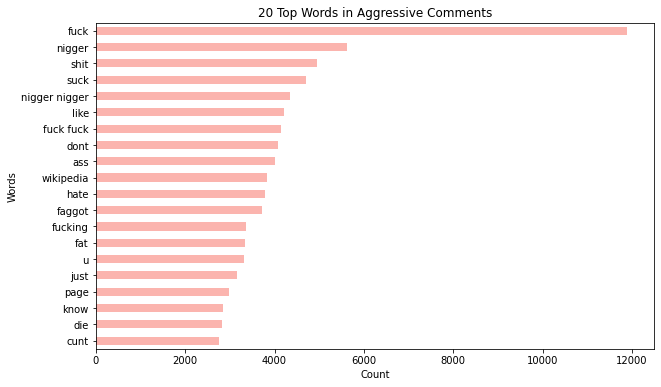

In [52]:
# Plot 20 top words in aggressive comments
plt.figure(figsize=(10,6))
comments_aggressive_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh', cmap='Pastel1')
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('20 Top Words in Aggressive Comments');

The top 20 words did not alter much from setting additional parameters on CountVectorizer.